In [42]:
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input, decode_predictions
import numpy as np
from skimage import io
from keras.preprocessing import image
from keras import backend as K
import matplotlib.pyplot as plt
import cv2
%matplotlib inline

In [7]:
model = VGG16(weights='imagenet')
img_path = r'C:\Users\nimro\Documents\Data\elephant.jpg'
img = image.load_img(img_path, target_size=(224, 224))
print(img)
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

<PIL.Image.Image image mode=RGB size=224x224 at 0x1C7A446B0F0>


In [12]:
preds = model.predict(x)
print('Predicted:', decode_predictions(preds, top=3)[0])
african_elephant_output = model.output[:, 386]
last_conv_layer = model.get_layer('block5_conv3')

Predicted: [('n02504458', 'African_elephant', 0.84742), ('n01871265', 'tusker', 0.11709757), ('n02408429', 'water_buffalo', 0.02328913)]


In [37]:
grads = K.gradients(african_elephant_output, last_conv_layer.output)[0] #creates placeholder for the gradients
pooled_grads = K.mean(grads, axis=(0, 1, 2)) #creates placeholder for the mean (on spatial dims) gradients for grad-cam
iterate = K.function([model.input],[pooled_grads, last_conv_layer.output[0]]) #creates function callback with placeholders
pooled_grads_value, conv_layer_output_value = iterate([x]) #actual function with actual data yields readl data values

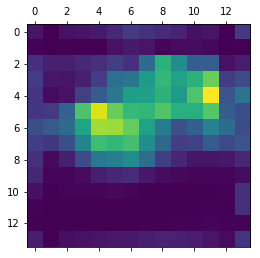

In [41]:
for i in range(512):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i] 
    #multiply each channed of last feature map with how importance does it have for predicting the speicfied class
    
heatmap = np.mean(conv_layer_output_value, axis=-1)
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)

In [69]:
img = cv2.imread(img_path)
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = heatmap * 0.5 + img
cv2.imwrite('c:/temp/img_.jpg', superimposed_img)

True